In [ ]:
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, utils, callbacks, optimizers, regularizers

!pip install -U transformers
!pip install sentencepiece

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
data1 = pd.read_csv('/content/drive/My Drive/thesis/feature_engineering/features_b.tsv', sep='\t', engine="python")
df = data1.filter(['q1','q2','annotation'], axis=1)
df = df.rename({'q1': 'question1', 'q2': 'question2' }, axis=1)

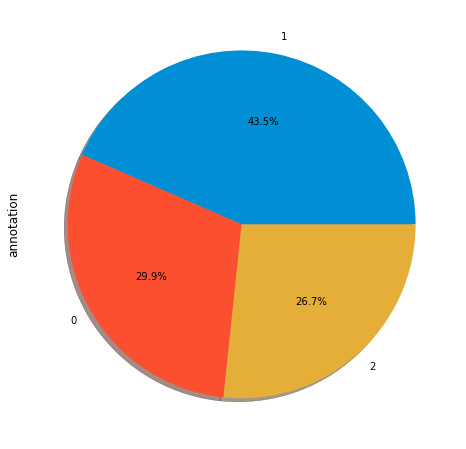

In [ ]:
plt.style.use('fivethirtyeight')
%matplotlib inline

f,ax=plt.subplots(1,figsize=(8,8))
df['annotation'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax,shadow=True)

In [ ]:

try:    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.89.172.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.89.172.114:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  grpc://10.89.172.114:8470
REPLICAS:  8


In [ ]:
model_name = 'jplu/tf-xlm-roberta-base'
n_epochs = 15
max_len = 22

# Our batch size will depend on number of replicas
batch_size = 8 * strategy.num_replicas_in_sync

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
df.isnull().sum()

question1     0
question2     0
annotation    0
dtype: int64

In [ ]:
#train = train.dropna(axis = 0)

In [ ]:
df.shape

(8299, 3)

In [ ]:
%%time

df_text = df[['question1', 'question2']].values.tolist()

# Now, we use the tokenizer we loaded to encode the text
df_encoded = tokenizer.batch_encode_plus(
    df_text,
    pad_to_max_length=True,
    max_length=max_len)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


CPU times: user 1.07 s, sys: 11.7 ms, total: 1.08 s
Wall time: 629 ms


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

y = df['annotation'].values
categorical_labels = to_categorical(y,num_classes=3)

x_train, x_test, y_train, y_test = train_test_split(df_encoded['input_ids'], categorical_labels, test_size=0.2, random_state=1024)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1024) # 0.25 x 0.8 = 0.2


#x_train, x_valid, y_train, y_valid = train_test_split(
#    train_encoded['input_ids'], 
#    categorical_labels, 
#    test_size=0.2, random_state=2020)



In [ ]:
auto = tf.data.experimental.AUTOTUNE

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(batch_size)
    .prefetch(auto)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_val, y_val))
    .batch(batch_size)
    .cache()
    .prefetch(auto)
)


In [ ]:
with strategy.scope():
    # First load the transformer layer
    transformer_encoder = TFAutoModel.from_pretrained(model_name)

    # This will be the input tokens 
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")

    # Now, we encode the text using the transformers we just loaded
    sequence_output = transformer_encoder(input_ids)[0]

    # Only extract the token used for classification, which is <s>
    cls_token = sequence_output[:, 0, :]

    # Finally, pass it through a 3-way softmax, since there's 3 possible laels
    out = Dense(3, activation='softmax')(cls_token)

    # It's time to build and compile the model
    model = Model(inputs=input_ids, outputs=out)
    model.compile(
        Adam(lr=1e-5), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
model.summary()

Some layers from the model checkpoint at jplu/tf-xlm-roberta-base were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 70)]              0         
                                                                 
 tfxlm_roberta_model (TFXLMR  TFBaseModelOutputWithPoo  278043648
 obertaModel)                lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             70, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
es = callbacks.EarlyStopping(
    monitor='accuracy', patience=10, verbose=1, restore_best_weights=True
)

rlp = callbacks.ReduceLROnPlateau(
    monitor='accuracy', factor=0.5, patience=1, min_lr=1e-5, mode='min', verbose=1
)

n_steps = len(x_train) // batch_size
history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=n_epochs,
    callbacks=[es, rlp]
)


Epoch 1/15


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 70) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 3) dtype=float32>]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:443: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 192001536 elements. This may consume a large amount of memory.
  num_elements)


Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'IteratorGetNext:0' shape=(None, 70) dtype=int32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 3) dtype=float32>]


77/77 [==============================] - ETA: 0s - loss: 1.1734 - accuracy: 0.3539

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 70) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 3) dtype=float32>]


77/77 [==============================] - 110s 385ms/step - loss: 1.1734 - accuracy: 0.3539 - val_loss: 1.0907 - val_accuracy: 0.3910 - lr: 1.0000e-05
Epoch 2/15
77/77 [==============================] - 14s 182ms/step - loss: 1.1152 - accuracy: 0.3835 - val_loss: 1.0692 - val_accuracy: 0.4319 - lr: 1.0000e-05
Epoch 3/15
77/77 [==============================] - 14s 184ms/step - loss: 1.1002 - accuracy: 0.4058 - val_loss: 1.0636 - val_accuracy: 0.4307 - lr: 1.0000e-05
Epoch 4/15
77/77 [==============================] - 14s 185ms/step - loss: 1.0709 - accuracy: 0.4257 - val_loss: 1.1295 - val_accuracy: 0.3572 - lr: 1.0000e-05
Epoch 5/15
77/77 [==============================] - 14s 184ms/step - loss: 1.0628 - accuracy: 0.4263 - val_loss: 1.0279 - val_accuracy: 0.4675 - lr: 1.0000e-05
Epoch 6/15
77/77 [==============================] - 14s 184ms/step - loss: 1.0365 - accuracy: 0.4521 - val_loss: 1.0379 - val_accuracy: 0.4771 - lr: 1.0000e-05
Epoch 7/15
77/77 [==============================] 

In [ ]:
preds = model.predict(x_test)
#print(classification_report(np.argmax(y_valid,axis=0),np.argmax(preds,axis=0)))


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 70) dtype=int64>]


In [ ]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(preds,axis=1)))

              precision    recall  f1-score   support

           0       0.54      0.55      0.54       480
           1       0.52      0.59      0.55       733
           2       0.47      0.37      0.41       447

    accuracy                           0.52      1660
   macro avg       0.51      0.50      0.50      1660
weighted avg       0.51      0.52      0.51      1660



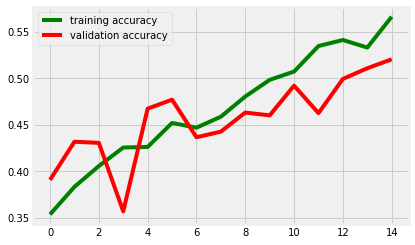

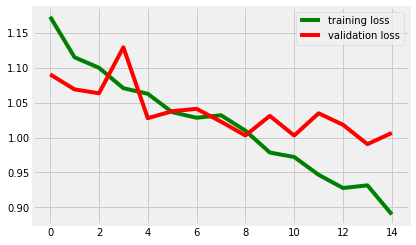

In [ ]:
accuracy = history.history["accuracy"]
loss = history.history["loss"]

val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

#plot 
plt.plot(accuracy,'g',label='training accuracy')
plt.plot(val_accuracy, 'r', label='validation accuracy')
plt.legend()
plt.show()

plt.plot(loss,'g',label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.legend()
plt.show()